## Using BeautifulSoup to scrape information for all TED talks on 8/16/2016

Time to scrape 63 pages of TED talks (all listed all of 8/16/2016).
Also storing all data in MongoDB.

The process overview:
1. Starting from the list of all TED talks, we will scrape the __date__, __name__, __event__, __URL__, and duration of every talk
2. With the URLs from part 1, we will scrape the __transcript__, __ratings__, and __views__ for each talk

Import _all_ the modules!
Also a small helper function.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import time
import random
import datetime
import dateutil.parser
import re
from pymongo import MongoClient

def to_date(datestring):
    '''Parse datestrings into datetime obejects'''
    date = dateutil.parser.parse(datestring)
    return date

def get_soup(url, headers):
    '''Given a url and headers, return a beautiful soup object with all the html on the page'''
    response = requests.get(url, headers)
    page = response.text
    soup = BeautifulSoup(page)
    delay = random.random()*0.5+0.5 #put in a randomized delay so the TED website doesn't block me
    time.sleep(delay)
    return soup

%matplotlib inline

Initialize connection to local MongoDB

In [3]:
client = MongoClient()
ted_db = client.ted_db
ted_names = ted_db.ted_names

Set scraping agent

In [2]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36'}
ted_url = 'https://www.ted.com/talks/quick-list?page='

For page 1 - 63, scrape name, duration, event, and URL. Store it as a list of dictionaries. Convert to Pandas for ease of use, and store in MongoDB.

In [224]:
talk_data = []
time_limit = pd.to_timedelta('30 min') # set timelimit for talk

for i in range(1,64): #63 pages of ted talks 
    print '\rWorking on row %d out of 63...' % i,len(talk_data),
    url = ted_url + str(i)
    soup = get_soup(url, headers)
    table_rows = soup.findAll("div", { "class" : "col xs-12 quick-list__container-row" })
    for row in table_rows:
        talk = {}

        date_html = row.findAll("div", { "class" : "col-xs-1"})[0]
        date_string = date_html.getText().strip()
        talk['date'] = date_string

        dur_html = row.findAll("div", { "class" : "col-xs-1"})[1] #storing this way for later conversion to pd.Timedelta
        dur_string = dur_html.getText().strip()
        try:
            dur = pd.to_timedelta(dur_string) 
        except:    
            dur_string = "00:" + dur_string
            dur = pd.to_timedelta(dur_string)
        talk['duration'] = dur_string
        
        event_html = row.find("div", { "class" : "col-xs-2 event"})
        event = event_html.getText().strip()
        talk['event'] = event

        title_html = row.find("div", { "class" : "col-xs-6 title"})
        title = title_html.getText().strip()
        url = title_html.find("a").attrs['href']
        talk['title'] = title
        talk['url'] = url
        
        if dur < time_limit:  #only include data if it's below the time limit
            talk_data.append(talk)
            prev_titles = ted_names.find({'title':title})
            if prev_titles.count() == 0:
                ted_names.insert_one(talk)

Working on row 63 out of 63... 2213


Before scraping more, let's explore the data.

In [225]:
df = pd.DataFrame(talk_data)
df.duration = pd.to_timedelta(df.duration)
df.date = pd.to_datetime(df.date)

2243

Histogram of TED talk durations

Definitely bimodal, maybe 2 normal distributions at 5 and 20 minutes?

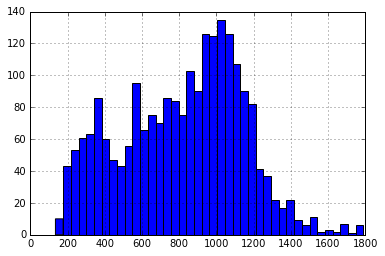

In [267]:
df.duration.astype('timedelta64[s]').hist(bins=40)

### Let's move on to scraping individual talk information - ratings, transcript, and views

In [512]:
df.ratings = np.nan
df.views = np.nan
df.transcripts = np.nan

In [14]:
""" Rating information is pulled into the website via JSON/javascript. 
 The script is pulled into Python and run, resulting in a list of dictionaries with the rating counts.
 I store a map of rating ID's to names in a seperate dictionary, and store the rating ID's and counts. 
 """
inform = re.compile('Informative')
start_time = time.time()

for index, end_url in df.url.iteritems():
    bad_urls = []
    progress = float(index-1464)/len(df[1465:])*100
    sofar = (time.time() - start_time)/60
    remaining = (100 - progress) * sofar / (progress+.001)
    print '\rPercent done: %.2f%%, Time elapsed (min): %.2f, Remaining time (min): %.2f ' % (progress, sofar, remaining),
    rating_counts = {}
    rating_script = ""
    base_url = "https://www.ted.com"    
    url = base_url + end_url
    soup = get_soup(url, headers)
    
    #get ratings
    while len(soup(text = inform)) == 0: #sometimes we get an ad in place of the ratings.
        soup = get_soup(url, headers)
    script = soup(text = inform)[0]
    start = script.find('ratings')+9
    end = script.find('relatedTalks') - 2
    rate_script = 'rating = ' + script[start:end]
    exec rate_script
    for rate in rating:
        rating_counts[rate['id']] = rate['count']
    df.loc[index, 'ratings'] = [rating_counts]   #assigning rating
    
    #get views
    views_html = soup.find('span', {"class" : "talk-sharing__value"})
    views = views_html.text.strip()
    df.loc[index, 'views'] = int(views.replace(",", "")) #assigning views
    
    #get transcript and timings
    trans_url = url + "/transcript?language=en"
    soup = get_soup(trans_url, headers)

    talk_html = soup.findAll('span',{'talk-transcript__fragment'} )
    frag_list = []
    for frag in talk_html:
        time_dict = {}
        text=frag.text.replace("\n", " ")
        tup = (text, int(frag.attrs['data-time']))
        frag_list.append(tup)
    if len(frag_list) != 0:
        df.loc[index, 'transcripts'] = [frag_list]
    else:
        bad_urls.append(trans_url)

In [25]:
df.to_pickle('transcripts.df')

## Insert data into MongoDB

In [24]:
for ind in df.index:
    tit = df.loc[ind, 'title']
    views = df.loc[ind, 'views']
    transcript = df.loc[ind, 'transcripts']
    ratings = df.loc[ind, 'ratings'][0]
    new_ratings = {}
    for k, v in ratings.iteritems():
        new_ratings[str(k)] = v
    ratings = new_ratings
    ted_names.update_one(
    {'title': tit},
    {'$set': {'views':views,'ratings':ratings, 'transcripts':transcript}}
        )

/Users/allenwko/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.


Scrape number of topics in TED talks

In [ ]:
url = 'https://www.ted.com/topics'
soup = get_soup(url, headers)

In [13]:
li = soup.findAll('li', {'class':'d:b'})
# for i in li:
#     print i.text.strip() #look at text, make sure they're all topics
len(li)

393

Looks like we got 393 topics to work with

Storing how TED labels their ratings.

In [359]:
rating_dict = {1: 'Beautiful',
                 2: 'Confusing',
                 3: 'Courageous',
                 7: 'Funny',
                 8: 'Informative',
                 9: 'Ingenious',
                 10: 'Inspiring',
                 11: 'Longwinded',
                 21: 'Unconvincing',
                 22: 'Fascinating',
                 23: 'Jaw-dropping',
                 24: 'Persuasive',
                 25: 'OK',
                 26: 'Obnoxious'}

{1: 'Beautiful',
 2: 'Confusing',
 3: 'Courageous',
 7: 'Funny',
 8: 'Informative',
 9: 'Ingenious',
 10: 'Inspiring',
 11: 'Longwinded',
 21: 'Unconvincing',
 22: 'Fascinating',
 23: 'Jaw-dropping',
 24: 'Persuasive',
 25: 'OK',
 26: 'Obnoxious'}